# Extract biomass for each validation point


In [1]:
try:
    import geopandas as gpd
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
    
import geopandas as gpd
import pandas as pd
from rasterio.coords import BoundingBox
from rasterio.coords import disjoint_bounds

import multiprocessing as mp

import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer
import contextily as ctx

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *
print("Importing packages complete.")
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Importing packages complete.


In [2]:
def getSample(raster, pts, data):
    src = rasterio.open(raster)
    sample = src.sample(pts)
    arr = np.fromiter(sample, dtype=np.float32) #src.profile['dtype']
    src.close()
    for ii in range(len(arr)):
        data[ii] = min(arr[ii], data[ii])
def extract_value_multi_thread(t_list: list, pt_gdf, sample_name: str, max_valid_value = 200, RESULT_DATA_TYPE = np.int16, NODATA_VAL = -9999):
#     # Check if variable points to a dir of rasters or a single raster
#     if len(os.path.splitext(r_path)[-1]) == 0:
#         # get a list of tiles
#         print("Get list of rasters")
#         t_list = glob.glob(os.path.join(r_path, "*.tif"))
#         print(f'Total number of tiles {len(t_list)}')
#     else:
#         print('Single raster')
#         t_list = [r_path]
        
    DO_REPROJ = True
    pt_gdf_prj_str = str(pt_gdf.crs).split(':')[-1]
    with rasterio.open(t_list[0]) as src:
        
        if pt_gdf_prj_str in str(src.crs):
            print(pt_gdf.crs)
            print(src.crs)
            print('no re-projection needed.')
            DO_REPROJ = False
            
    if DO_REPROJ:
        # project gdf to rasters's CRS
        print("Re-project points to match raster")
        tmp = rasterio.open(t_list[0])
        pt_gdf = pt_gdf.to_crs(tmp.crs)
        tmp.close()
            
    print('extract points coords')
    pt_coord = [(pt.x, pt.y) for pt in pt_gdf.geometry]
    
    print('get boundingbox from points')
    bnd = pt_gdf.total_bounds
    pt_bnd = BoundingBox(bnd[0], bnd[1], bnd[2], bnd[3])
    
    print('loop through tiles & update sample values')
    print("Sampling rasters ...")
    
    r = mp.Array('i', np.full(len(pt_coord), NODATA_VAL)) # <-- this background value should not be negative and not be within the valid data range
    jobs = []
    
    ### TO RUN A SHORT TEST
    ### for fn in t_list[:100]:
    for fn in t_list:
        
        ds = rasterio.open(fn)
        r_bnd = ds.bounds
        ds.close()
        if not disjoint_bounds(r_bnd, pt_bnd):
            j = mp.Process(target=getSample, args=(fn, pt_coord, r))
            jobs.append(j)
            j.start()
        #else:
        #    print(f"PASS   {os.path.basename(fn)}")
            
    for j in jobs:
        j.join()
        
    ## merge sample back to gdf
    print("Add new column")
    rslt = np.array(r[:]).astype(RESULT_DATA_TYPE)
    rslt = np.where(rslt <= max_valid_value, rslt, NODATA_VAL)
    pt_gdf[sample_name] = pd.Categorical(rslt)
    
    print("Complete")
    
    return pt_gdf

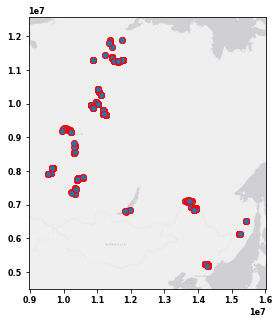

In [56]:
z = pd.read_csv('/projects/my-public-bucket/analyze_agb/eurasia_forest_structure_plots_smrytrees.csv',keep_default_na=False, na_values=['NA'])
#z = pd.DataFrame({'lon': [-150.0], 'lat': [65.0]})

z["lon"] = z.lon.astype(float)
z["lat"] = z.lat.astype(float)

z_gdf = gpd.GeoDataFrame(z[['lon','lat']], geometry=gpd.points_from_xy(z.lon, z.lat), crs='epsg:4326')
ax = z_gdf.to_crs(3857).plot(figsize=(5, 5), edgecolor='red')
plt.margins(y=0.1, x=0.1)
ctx.add_basemap(ax,  source="http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}")

In [42]:
z_gdf[~z_gdf.lat.isna()]

,lon,lat,geometry
0,123.09014,53.88483,POINT (123.09014 53.88483)
1,122.91742,53.60714,POINT (122.91742 53.60714)
2,125.28197,52.54544,POINT (125.28197 52.54544)
3,125.28158,52.54390,POINT (125.28158 52.54390)
4,125.25319,52.43282,POINT (125.25319 52.43282)
...,...,...,...
644,105.45200,72.40400,POINT (105.45200 72.40400)
645,100.81300,71.10000,POINT (100.81300 71.10000)
646,100.84600,71.10600,POINT (100.84600 71.10600)
647,102.09800,72.15100,POINT (102.09800 72.15100)


### This doesnt work using full VRT  - instead, need to divide input points according to raster's tile system, then loop tile by tile doing the extraction
VRT loads into memory and crashes VM

In [ ]:
raster_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt'
a = ExtractUtils.extract_value_gdf(raster_fn, z_gdf[~z_gdf.lat.isna()], bandnames=['agb_mean'], reproject=True)

	Extracting raster values from:  /projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt
	Re-project points to match raster...


### This doesnt work either
Get list of tiles that intersect the points

In [40]:
tiles_list = gpd.overlay(z_gdf, tindex, how='intersection').s3_path.to_list()
# remove duplicates
tiles_list = list(set(tiles_list))

In [73]:
with rasterio.open(tiles_list[0]) as src_dataset:
    kwds = src_dataset.profile
    print(src_dataset.profile['dtype'])
    #kwds['dtype'] = 'uint16'
    #src_meta = src_dataset.meta

float32


In [81]:
a = extract_value_multi_thread(tiles_list, z_gdf[~z_gdf.lat.isna()], 'agb_mean',
                               max_valid_value = 1000.0, RESULT_DATA_TYPE = np.float32, NODATA_VAL = -9999)

Re-project points to match raster
extract points coords
get boundingbox from points
loop through tiles & update sample values
Sampling rasters ...


Process Process-253:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3708/2644680287.py", line 4, in getSample
    arr = np.fromiter(sample, dtype=np.float32) #src.profile['dtype']
ValueError: setting an array element with a sequence.
Process Process-254:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self.

Add new column
Complete


In [47]:
a.agb_mean.to_list()

[500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
